C:\Users\c903_w\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating element embeddings...
Generating embeddings for 100 elements...
Embeddings shape: (100, 768)

Visualizing element embeddings...
Performing t-SNE dimensionality reduction...


C:\Users\c903_w\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Creating t-SNE visualization figure...
Adjusting label positions to avoid overlap...


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


t-SNE visualization saved as: t_sne_chemical_element_embeddings.png


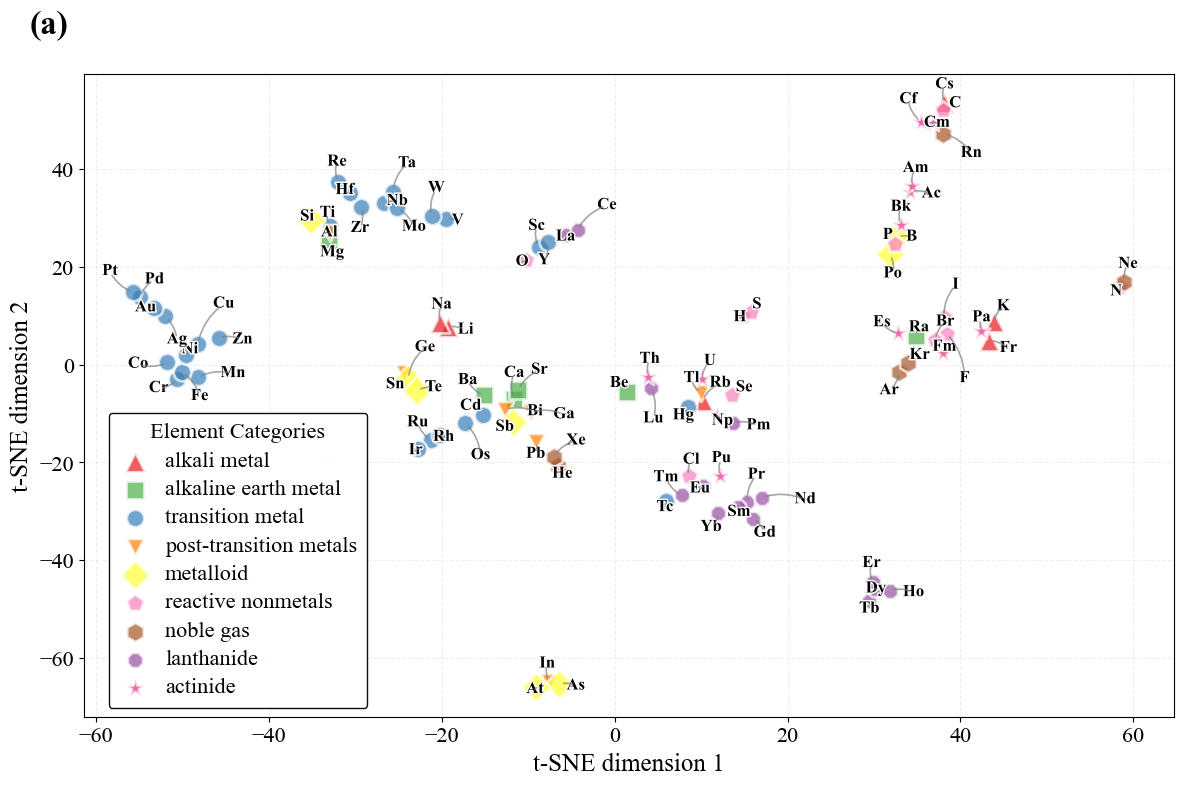


Creating clean periodic table visualization...


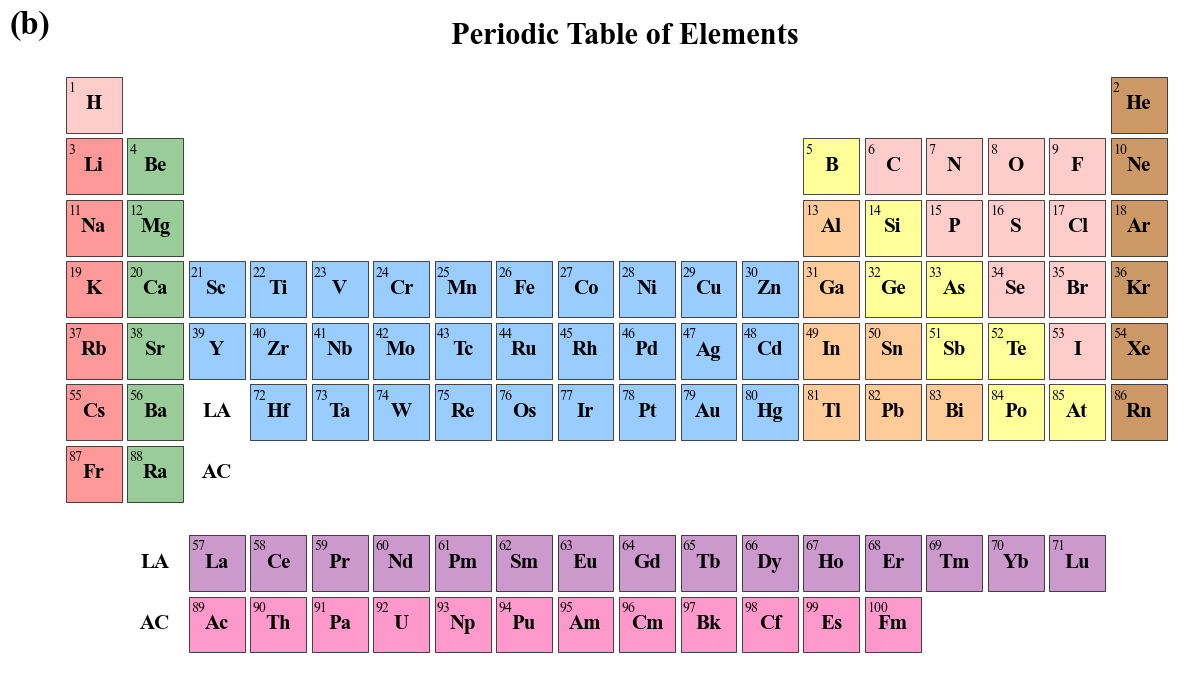


Analyzing HEA embedding space...

HEA EMBEDDING SPACE ANALYSIS (768-dim, Cosine Similarity)

1. HEA vs NON-HEA CLUSTERING
--------------------------------------------------
Average internal distance (HEA elements): 0.2077
Average internal distance (non-HEA elements): 0.2998
Ratio: 0.6929

2. CANTOR ALLOY SYSTEM (Fe-Cr-Mn-Co-Ni) COHESION
--------------------------------------------------
Cantor alloy internal distance: 0.1072

3. KEY ELEMENT PAIR SIMILARITY
--------------------------------------------------
Ti-Al cosine similarity: 90.2%

4. HIGH-SIMILARITY TRIPLETS
--------------------------------------------------
Pr-Nd-Sm average similarity: 0.91

Searching for high-similarity triplets...

Top 5 high-similarity HEA triplets:
  1. Pr-Nd-Sm        (avg similarity: 0.91)
  2. Pr-Sm-Eu        (avg similarity: 0.91)
  3. Cr-Mn-Fe        (avg similarity: 0.91)
  4. Cr-Fe-Co        (avg similarity: 0.90)
  5. Pr-Nd-Eu        (avg similarity: 0.90)

ANALYSIS COMPLETE

Saving results...
Resu

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import pandas as pd
from collections import defaultdict
import matplotlib.patheffects as patheffects
import matplotlib.patches as patches
from scipy.spatial.distance import pdist, squareform, cosine


def get_periodic_table_elements():
    """Get the first 100 chemical elements and their categories"""
    elements = [
        # Atomic number, Symbol, Name, Category
        (1, "H", "Hydrogen", "reactive nonmetals"),
        (2, "He", "Helium", "noble gas"),
        (3, "Li", "Lithium", "alkali metal"),
        (4, "Be", "Beryllium", "alkaline earth metal"),
        (5, "B", "Boron", "metalloid"),
        (6, "C", "Carbon", "reactive nonmetals"),
        (7, "N", "Nitrogen", "reactive nonmetals"),
        (8, "O", "Oxygen", "reactive nonmetals"),
        (9, "F", "Fluorine", "reactive nonmetals"),
        (10, "Ne", "Neon", "noble gas"),
        (11, "Na", "Sodium", "alkali metal"),
        (12, "Mg", "Magnesium", "alkaline earth metal"),
        (13, "Al", "Aluminium", "post-transition metals"),
        (14, "Si", "Silicon", "metalloid"),
        (15, "P", "Phosphorus", "reactive nonmetals"),
        (16, "S", "Sulfur", "reactive nonmetals"),
        (17, "Cl", "Chlorine", "reactive nonmetals"),
        (18, "Ar", "Argon", "noble gas"),
        (19, "K", "Potassium", "alkali metal"),
        (20, "Ca", "Calcium", "alkaline earth metal"),
        (21, "Sc", "Scandium", "transition metal"),
        (22, "Ti", "Titanium", "transition metal"),
        (23, "V", "Vanadium", "transition metal"),
        (24, "Cr", "Chromium", "transition metal"),
        (25, "Mn", "Manganese", "transition metal"),
        (26, "Fe", "Iron", "transition metal"),
        (27, "Co", "Cobalt", "transition metal"),
        (28, "Ni", "Nickel", "transition metal"),
        (29, "Cu", "Copper", "transition metal"),
        (30, "Zn", "Zinc", "transition metal"),
        (31, "Ga", "Gallium", "post-transition metals"),
        (32, "Ge", "Germanium", "metalloid"),
        (33, "As", "Arsenic", "metalloid"),
        (34, "Se", "Selenium", "reactive nonmetals"),
        (35, "Br", "Bromine", "reactive nonmetals"),
        (36, "Kr", "Krypton", "noble gas"),
        (37, "Rb", "Rubidium", "alkali metal"),
        (38, "Sr", "Strontium", "alkaline earth metal"),
        (39, "Y", "Yttrium", "transition metal"),
        (40, "Zr", "Zirconium", "transition metal"),
        (41, "Nb", "Niobium", "transition metal"),
        (42, "Mo", "Molybdenum", "transition metal"),
        (43, "Tc", "Technetium", "transition metal"),
        (44, "Ru", "Ruthenium", "transition metal"),
        (45, "Rh", "Rhodium", "transition metal"),
        (46, "Pd", "Palladium", "transition metal"),
        (47, "Ag", "Silver", "transition metal"),
        (48, "Cd", "Cadmium", "transition metal"),
        (49, "In", "Indium", "post-transition metals"),
        (50, "Sn", "Tin", "post-transition metals"),
        (51, "Sb", "Antimony", "metalloid"),
        (52, "Te", "Tellurium", "metalloid"),
        (53, "I", "Iodine", "reactive nonmetals"),
        (54, "Xe", "Xenon", "noble gas"),
        (55, "Cs", "Caesium", "alkali metal"),
        (56, "Ba", "Barium", "alkaline earth metal"),
        (57, "La", "Lanthanum", "lanthanide"),
        (58, "Ce", "Cerium", "lanthanide"),
        (59, "Pr", "Praseodymium", "lanthanide"),
        (60, "Nd", "Neodymium", "lanthanide"),
        (61, "Pm", "Promethium", "lanthanide"),
        (62, "Sm", "Samarium", "lanthanide"),
        (63, "Eu", "Europium", "lanthanide"),
        (64, "Gd", "Gadolinium", "lanthanide"),
        (65, "Tb", "Terbium", "lanthanide"),
        (66, "Dy", "Dysprosium", "lanthanide"),
        (67, "Ho", "Holmium", "lanthanide"),
        (68, "Er", "Erbium", "lanthanide"),
        (69, "Tm", "Thulium", "lanthanide"),
        (70, "Yb", "Ytterbium", "lanthanide"),
        (71, "Lu", "Lutetium", "lanthanide"),
        (72, "Hf", "Hafnium", "transition metal"),
        (73, "Ta", "Tantalum", "transition metal"),
        (74, "W", "Tungsten", "transition metal"),
        (75, "Re", "Rhenium", "transition metal"),
        (76, "Os", "Osmium", "transition metal"),
        (77, "Ir", "Iridium", "transition metal"),
        (78, "Pt", "Platinum", "transition metal"),
        (79, "Au", "Gold", "transition metal"),
        (80, "Hg", "Mercury", "transition metal"),
        (81, "Tl", "Thallium", "post-transition metals"),
        (82, "Pb", "Lead", "post-transition metals"),
        (83, "Bi", "Bismuth", "post-transition metals"),
        (84, "Po", "Polonium", "metalloid"),
        (85, "At", "Astatine", "metalloid"),
        (86, "Rn", "Radon", "noble gas"),
        (87, "Fr", "Francium", "alkali metal"),
        (88, "Ra", "Radium", "alkaline earth metal"),
        (89, "Ac", "Actinium", "actinide"),
        (90, "Th", "Thorium", "actinide"),
        (91, "Pa", "Protactinium", "actinide"),
        (92, "U", "Uranium", "actinide"),
        (93, "Np", "Neptunium", "actinide"),
        (94, "Pu", "Plutonium", "actinide"),
        (95, "Am", "Americium", "actinide"),
        (96, "Cm", "Curium", "actinide"),
        (97, "Bk", "Berkelium", "actinide"),
        (98, "Cf", "Californium", "actinide"),
        (99, "Es", "Einsteinium", "actinide"),
        (100, "Fm", "Fermium", "actinide"),
    ]
    
    # Convert to dictionary format
    element_data = []
    for atomic_num, symbol, name, category in elements:
        element_data.append({
            'atomic_number': atomic_num,
            'symbol': symbol,
            'name': name,
            'category': category
        })
    
    return element_data


def generate_element_embeddings(model_path, batch_size=16):
    """Generate embedding vectors for chemical elements"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Get element data
    elements = get_periodic_table_elements()
    element_symbols = [e['symbol'] for e in elements]
    
    print(f"Generating embeddings for {len(element_symbols)} elements...")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path).to(device)
    model.eval()
    
    all_embeddings = []
    
    # Process element symbols in batches
    for i in range(0, len(element_symbols), batch_size):
        batch_symbols = element_symbols[i:i + batch_size]
        
        # Tokenize
        inputs = tokenizer(
            batch_symbols, 
            return_tensors='pt', 
            padding=True, 
            truncation=True,
            max_length=512
        ).to(device)

        # Get [CLS] embeddings
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]
        cls_embeddings = last_hidden_state[:, 0, :]

        all_embeddings.append(cls_embeddings.cpu().numpy())
    
    # Merge embeddings from all batches
    embeddings = np.vstack(all_embeddings)
    
    print(f"Embeddings shape: {embeddings.shape}")
    
    # Add embeddings to element data
    for i, element in enumerate(elements):
        element['embedding'] = embeddings[i]
    
    return elements


def visualize_element_embeddings(elements, title="Element Embeddings Visualization"):
    """Visualize element embeddings (two separate figures)"""
    from adjustText import adjust_text
    
    # Set global font to Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12
    
    # Extract embeddings and metadata
    embeddings = np.array([e['embedding'] for e in elements])
    symbols = [e['symbol'] for e in elements]
    categories = [e['category'] for e in elements]
    
    print(f"Performing t-SNE dimensionality reduction...")
    
    # Use t-SNE for 2D reduction
    tsne = TSNE(
        n_components=2,
        perplexity=2,
        metric='cosine',
        random_state=42,
        n_iter=1000
    )
    
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # High saturation colors for projection display
    category_colors = {
        'alkali metal': '#E41A1C',
        'alkaline earth metal': '#4DAF4A',
        'transition metal': '#377EB8',
        'post-transition metals': '#FF7F00',
        'metalloid': '#FFFF33',
        'reactive nonmetals': '#F781BF',
        'noble gas': '#A65628',
        'lanthanide': '#984EA3',
        'actinide': '#E7298A',
    }
    
    # Different markers for each category
    category_markers = {
        'alkali metal': '^',
        'alkaline earth metal': 's',
        'transition metal': 'o',
        'post-transition metals': 'v',
        'metalloid': 'D',
        'reactive nonmetals': 'p',
        'noble gas': 'h',
        'lanthanide': '8',
        'actinide': '*',
    }
    
    # Marker sizes
    marker_sizes = {
        'alkali metal': 200,
        'alkaline earth metal': 180,
        'transition metal': 160,
        'post-transition metals': 150,
        'metalloid': 220,
        'reactive nonmetals': 170,
        'noble gas': 190,
        'lanthanide': 140,
        'actinide': 180,
    }
    
    # ============ Figure 1: t-SNE visualization with smart labels ============
    print("\nCreating t-SNE visualization figure...")
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    
    # Add (a) label in top left corner
    ax1.text(-0.05, 1.10, '(a)', transform=ax1.transAxes, 
             fontsize=24, fontweight='bold', va='top', ha='left')
    
    # Store all text objects
    texts = []
    
    # Plot scatter by category with different markers
    for category, color in category_colors.items():
        mask = [c == category for c in categories]
        if any(mask):
            category_indices = np.where(mask)[0]
            x = embeddings_2d[mask, 0]
            y = embeddings_2d[mask, 1]
            
            marker = category_markers.get(category, 'o')
            size = marker_sizes.get(category, 200)
            
            ax1.scatter(x, y, c=color, label=category, s=size, alpha=0.7, 
                       edgecolors='white', linewidths=2, marker=marker, zorder=2)
            
            # Create text objects with white stroke for readability
            for idx in range(len(x)):
                text = ax1.text(x[idx], y[idx], symbols[category_indices[idx]],
                              fontsize=12,
                              fontweight='bold',
                              ha='center',
                              va='center',
                              color='black',
                              path_effects=[patheffects.withStroke(linewidth=2, foreground='white')],
                              zorder=3)
                texts.append(text)
    
    print("Adjusting label positions to avoid overlap...")

    adjust_text(texts,
                ax=ax1,
                arrowprops=dict(arrowstyle='-',
                            color='gray',
                            lw=1.2,
                            alpha=0.7,
                            shrinkA=3,
                            shrinkB=3,
                            connectionstyle='arc3,rad=0.2'),
                expand_points=(1.5, 1.8),
                expand_text=(1.2, 1.4),
                force_text=(0.8, 1.2),
                force_points=(0.1, 0.3),
                lim=800,
                precision=0.01,
                only_move={'points': 'none', 'text': 'xy'},
                avoid_self=False,
                autoalign='xy',
                va='center',
                ha='center')
    
    # Set chart properties
    ax1.set_xlabel('t-SNE dimension 1', fontsize=18, fontname='Times New Roman')
    ax1.set_ylabel('t-SNE dimension 2', fontsize=18, fontname='Times New Roman')
    
    # Set tick label font
    for tick in ax1.get_xticklabels() + ax1.get_yticklabels():
        tick.set_fontsize(16)
        tick.set_fontname('Times New Roman')
    
    # Create legend
    handles = []
    for category, color in category_colors.items():
        if category in categories:
            marker = category_markers.get(category, 'o')
            size = marker_sizes.get(category, 200)
            handles.append(plt.scatter([], [], c=color, label=category, 
                                      s=size, alpha=0.7, edgecolors='white', 
                                      linewidths=2, marker=marker))
    
    if handles:
        legend = ax1.legend(handles=handles, 
                        title='Element Categories', 
                        prop={'family': 'Times New Roman', 'size': 12},
                        title_fontsize=16,
                        loc='lower left',
                        bbox_to_anchor=(0.015, 0.001),
                        framealpha=0.95,
                        edgecolor='black',
                        fancybox=True,
                        shadow=False,
                        borderpad=0.6,
                        ncol=1)
        
        legend.get_title().set_fontname('Times New Roman')
        legend.get_title().set_size(16)
        
        for text in legend.get_texts():
            text.set_fontsize(16)
            text.set_fontname('Times New Roman')
    
    ax1.grid(True, alpha=0.2, linestyle='--')
    
    plt.tight_layout()
    t_sne_filename = f"t_sne_{title.replace(' ', '_').lower()}.png"
    plt.savefig(t_sne_filename, dpi=300, bbox_inches='tight')
    print(f"t-SNE visualization saved as: {t_sne_filename}")
    plt.show()

    # ============ Figure 2: Clean periodic table layout ============
    print("\nCreating clean periodic table visualization...")

    # Cell settings for periodic table
    cell_length = 1
    cell_gap = 0.1
    cell_edge_width = 0.5

    # Manual period and group mapping based on periodic table layout
    period_group_map = {
        1: (1, 1), 2: (18, 1),
        3: (1, 2), 4: (2, 2), 5: (13, 2), 6: (14, 2), 7: (15, 2), 8: (16, 2), 9: (17, 2), 10: (18, 2),
        11: (1, 3), 12: (2, 3), 13: (13, 3), 14: (14, 3), 15: (15, 3), 16: (16, 3), 17: (17, 3), 18: (18, 3),
        19: (1, 4), 20: (2, 4),
        21: (3, 4), 22: (4, 4), 23: (5, 4), 24: (6, 4), 25: (7, 4), 26: (8, 4), 27: (9, 4), 28: (10, 4), 29: (11, 4), 30: (12, 4),
        31: (13, 4), 32: (14, 4), 33: (15, 4), 34: (16, 4), 35: (17, 4), 36: (18, 4),
        37: (1, 5), 38: (2, 5),
        39: (3, 5), 40: (4, 5), 41: (5, 5), 42: (6, 5), 43: (7, 5), 44: (8, 5), 45: (9, 5), 46: (10, 5), 47: (11, 5), 48: (12, 5),
        49: (13, 5), 50: (14, 5), 51: (15, 5), 52: (16, 5), 53: (17, 5), 54: (18, 5),
        55: (1, 6), 56: (2, 6),
        # Lanthanides (57-71) in row 8
        57: (3, 8), 58: (4, 8), 59: (5, 8), 60: (6, 8), 61: (7, 8), 62: (8, 8), 63: (9, 8), 64: (10, 8), 
        65: (11, 8), 66: (12, 8), 67: (13, 8), 68: (14, 8), 69: (15, 8), 70: (16, 8), 71: (17, 8),
        # 72-86 in row 6
        72: (4, 6), 73: (5, 6), 74: (6, 6), 75: (7, 6), 76: (8, 6), 77: (9, 6), 78: (10, 6), 79: (11, 6), 80: (12, 6),
        81: (13, 6), 82: (14, 6), 83: (15, 6), 84: (16, 6), 85: (17, 6), 86: (18, 6),
        87: (1, 7), 88: (2, 7),
        # Actinides (89-100) in row 9
        89: (3, 9), 90: (4, 9), 91: (5, 9), 92: (6, 9), 93: (7, 9), 94: (8, 9), 95: (9, 9), 96: (10, 9),
        97: (11, 9), 98: (12, 9), 99: (13, 9), 100: (14, 9),
    }
    
    # Light colors for projection display
    category_colors_light = {
        'alkali metal': '#FF9999',
        'alkaline earth metal': '#99CC99',
        'transition metal': '#99CCFF',
        'post-transition metals': '#FFCC99',
        'metalloid': '#FFFF99',
        'reactive nonmetals': '#FFCCCC',
        'noble gas': '#CC9966',
        'lanthanide': '#CC99CC',
        'actinide': '#FF99CC',
    }
    
    # Process element data with period and group info
    processed_elements = []
    for ele in elements:
        atomic_number = ele['atomic_number']
        symbol = ele['symbol']
        category = ele['category']
        
        if atomic_number in period_group_map:
            group, period = period_group_map[atomic_number]
            processed_elements.append({
                'atomic_number': atomic_number,
                'symbol': symbol,
                'category': category,
                'group': group,
                'period': period
            })

    # Set La and Ac series annotation labels
    marker_elements = [
        {'atomic_number': None, 'symbol': 'LA', 'group': 3, 'period': 6, 'category': None},
        {'atomic_number': None, 'symbol': 'AC', 'group': 3, 'period': 7, 'category': None},
        {'atomic_number': None, 'symbol': 'LA', 'group': 2, 'period': 8, 'category': None},
        {'atomic_number': None, 'symbol': 'AC', 'group': 2, 'period': 9, 'category': None},
    ]

    # Create new figure
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    
    # Add (b) label in top left corner
    ax2.text(-0.05, 1.10, '(b)', transform=ax2.transAxes, 
             fontsize=24, fontweight='bold', va='top', ha='left', 
             fontname='Times New Roman')
    
    # x, y axis range
    xy_length = (20, 11)

    # Draw periodic table cells with category colors
    for ele in processed_elements:
        atomic_number = ele['atomic_number']
        symbol = ele['symbol']
        group = ele['group']
        period = ele['period']
        category = ele['category']

        if group is None:
            continue

        # x, y position of cell
        x = (cell_length + cell_gap) * (group - 1)
        y = xy_length[1] - ((cell_length + cell_gap) * period)

        # Add spacing for La, Ac series
        if period >= 8:
            y -= cell_length * 0.5

        # Draw cell border and fill with category color
        if atomic_number:
            fill_color = category_colors_light.get(category, '#F0F0F0')
            rect = patches.Rectangle(xy=(x, y),
                                    width=cell_length, height=cell_length,
                                    linewidth=cell_edge_width,
                                    edgecolor='k',
                                    facecolor=fill_color)
            ax2.add_patch(rect)

        # Add atomic number in cell
        ax2.text(x + 0.04, y + 0.8,
                str(atomic_number) if atomic_number else '',
                va='center', ha='left',
                fontdict={'size': 10, 'color': 'black', 'family': 'Times New Roman'})
        # Add element symbol in cell
        ax2.text(x + 0.5, y + 0.5,
                symbol,
                va='center', ha='center',
                fontdict={'size': 15, 'color': 'black', 'family': 'Times New Roman', 'weight': 'bold'})

    # Draw La and Ac series markers
    for ele in marker_elements:
        atomic_number = ele['atomic_number']
        symbol = ele['symbol']
        group = ele['group']
        period = ele['period']
        
        x = (cell_length + cell_gap) * (group - 1)
        y = xy_length[1] - ((cell_length + cell_gap) * period)

        if period >= 8:
            y -= cell_length * 0.5
        
        ax2.text(x + 0.5, y + 0.5,
                symbol,
                va='center', ha='center',
                fontdict={'size': 15, 'color': 'black', 'family': 'Times New Roman', 'weight': 'bold'})

    # Set equal aspect ratio
    ax2.set_aspect('equal')
    ax2.axis('off')
    ax2.set_ylim(0, xy_length[1])
    ax2.set_xlim(0, xy_length[0])

    ax2.set_title('Periodic Table of Elements', fontsize=22, fontweight='bold', 
                  pad=20, fontname='Times New Roman')

    plt.tight_layout()
    plt.savefig('periodic_table_first_100.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    return embeddings_2d


def analyze_hea_embedding_space(elements):
    """Analyze HEA elements in embedding space using cosine similarity"""
    print("\n" + "="*70)
    print("HEA EMBEDDING SPACE ANALYSIS (768-dim, Cosine Similarity)")
    print("="*70)
    
    symbols = [e['symbol'] for e in elements]
    full_embeddings = np.array([e['embedding'] for e in elements])
    
    # Calculate cosine distance matrix
    distances = squareform(pdist(full_embeddings, metric='cosine'))
    
    # Define HEA core elements
    HEA_CORE_ELEMENTS = {
        'Cantor_base': ['Fe', 'Co', 'Ni', 'Cr', 'Mn'],
        'Refractory': ['Ti', 'Zr', 'Hf', 'V', 'Nb', 'Ta', 'Cr', 'Mo', 'W'],
        'Lightweight': ['Al', 'Ti', 'Mg', 'Li', 'Sc'],
        'Rare_earth': ['Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu'],
    }
    
    # Merge all HEA elements
    all_hea_elements = []
    for elem_list in HEA_CORE_ELEMENTS.values():
        all_hea_elements.extend(elem_list)
    all_hea_elements = list(set(all_hea_elements))
    
    # 1. HEA vs non-HEA clustering analysis
    print("\n1. HEA vs NON-HEA CLUSTERING")
    print("-" * 50)
    
    hea_indices = [symbols.index(elem) for elem in all_hea_elements if elem in symbols]
    non_hea_indices = [i for i in range(len(elements)) if i not in hea_indices]
    
    # Calculate average internal distance for HEA elements
    hea_distances = []
    for i in range(len(hea_indices)):
        for j in range(i + 1, len(hea_indices)):
            hea_distances.append(distances[hea_indices[i], hea_indices[j]])
    avg_hea_distance = np.mean(hea_distances)
    
    # Calculate average internal distance for non-HEA elements
    non_hea_distances = []
    for i in range(len(non_hea_indices)):
        for j in range(i + 1, len(non_hea_indices)):
            non_hea_distances.append(distances[non_hea_indices[i], non_hea_indices[j]])
    avg_non_hea_distance = np.mean(non_hea_distances)
    
    print(f"Average internal distance (HEA elements): {avg_hea_distance:.4f}")
    print(f"Average internal distance (non-HEA elements): {avg_non_hea_distance:.4f}")
    print(f"Ratio: {avg_hea_distance/avg_non_hea_distance:.4f}")
    
    # 2. Cantor alloy system cohesion
    print("\n2. CANTOR ALLOY SYSTEM (Fe-Cr-Mn-Co-Ni) COHESION")
    print("-" * 50)
    
    cantor_elements = ['Fe', 'Cr', 'Mn', 'Co', 'Ni']
    cantor_indices = [symbols.index(elem) for elem in cantor_elements if elem in symbols]
    
    cantor_distances = []
    for i in range(len(cantor_indices)):
        for j in range(i + 1, len(cantor_indices)):
            cantor_distances.append(distances[cantor_indices[i], cantor_indices[j]])
    avg_cantor_distance = np.mean(cantor_distances)
    
    print(f"Cantor alloy internal distance: {avg_cantor_distance:.4f}")
    
    # 3. Element pair similarity (Ti-Al)
    print("\n3. KEY ELEMENT PAIR SIMILARITY")
    print("-" * 50)
    
    ti_idx = symbols.index('Ti')
    al_idx = symbols.index('Al')
    ti_al_similarity = 1 - distances[ti_idx, al_idx]
    
    print(f"Ti-Al cosine similarity: {ti_al_similarity*100:.1f}%")
    
    # 4. High-similarity triplets (Pr-Nd-Sm)
    print("\n4. HIGH-SIMILARITY TRIPLETS")
    print("-" * 50)
    
    # Calculate Pr-Nd-Sm triplet similarity
    pr_idx = symbols.index('Pr')
    nd_idx = symbols.index('Nd')
    sm_idx = symbols.index('Sm')
    
    pr_nd_sim = 1 - distances[pr_idx, nd_idx]
    pr_sm_sim = 1 - distances[pr_idx, sm_idx]
    nd_sm_sim = 1 - distances[nd_idx, sm_idx]
    avg_triplet_sim = (pr_nd_sim + pr_sm_sim + nd_sm_sim) / 3
    
    print(f"Pr-Nd-Sm average similarity: {avg_triplet_sim:.2f}")
    
    # Find other high-similarity triplets
    print("\nSearching for high-similarity triplets...")
    candidate_triplets = []
    
    for i in range(len(elements)):
        for j in range(i + 1, len(elements)):
            for k in range(j + 1, len(elements)):
                avg_similarity = (1 - distances[i, j] + 
                                 1 - distances[i, k] + 
                                 1 - distances[j, k]) / 3
                
                elem_symbols = [symbols[i], symbols[j], symbols[k]]
                hea_count = sum(1 for elem in elem_symbols if elem in all_hea_elements)
                
                if hea_count >= 2 and avg_similarity > 0.85:
                    candidate_triplets.append((avg_similarity, elem_symbols))
    
    candidate_triplets.sort(key=lambda x: x[0], reverse=True)
    
    print("\nTop 5 high-similarity HEA triplets:")
    for rank, (sim, triplet) in enumerate(candidate_triplets[:5], 1):
        print(f"  {rank}. {'-'.join(triplet):15s} (avg similarity: {sim:.2f})")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    return distances


# Main program
if __name__ == "__main__":
    # Model path
    model_path = "..//DeBERTa//model_results_save//final_model"
    
    # Generate element embeddings
    print("Generating element embeddings...")
    elements = generate_element_embeddings(model_path, batch_size=16)
    
    # Visualize embeddings (two figures)
    print("\nVisualizing element embeddings...")
    embeddings_2d = visualize_element_embeddings(elements, title="Chemical Element Embeddings")
    
    # Analyze HEA embedding space
    print("\nAnalyzing HEA embedding space...")
    distances = analyze_hea_embedding_space(elements)
    
    # Save results
    print("\nSaving results...")
    full_embeddings = np.array([e['embedding'] for e in elements])
    results = []
    for i, element in enumerate(elements):
        results.append({
            'atomic_number': element['atomic_number'],
            'symbol': element['symbol'],
            'name': element['name'],
            'category': element['category'],
            'tsne_x': embeddings_2d[i, 0],
            'tsne_y': embeddings_2d[i, 1],
            'embedding_norm': np.linalg.norm(full_embeddings[i]),
        })
    
    df_results = pd.DataFrame(results)
    df_results.to_csv('element_embeddings_analysis.csv', index=False)
    print("Results saved to 'element_embeddings_analysis.csv'")